In [323]:
# import dependencies 
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss, \
    precision_score, recall_score, precision_recall_curve, average_precision_score, \
    confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import os
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from pdpbox import pdp
from sklearn.calibration import calibration_curve 
from sklearn.base import clone 
%matplotlib inline 

# Load Data

In [286]:
# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/"

In [288]:
# load data 
df = pd.read_csv(os.path.join(DATAFOLDER, "data_for_model/appeals_data_final.csv"))
df.set_index('idnAppeal', inplace=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 242466 entries, 4657002.0 to 5021568.0
Data columns (total 43 columns):
idncase                                242466 non-null int64
idnproceeding                          242466 non-null int64
nat_grouped                            242466 non-null object
lang_grouped                           242466 non-null object
ij_code_grouped                        242466 non-null object
Male_judge                             226481 non-null float64
Year_Appointed_SLR                     226481 non-null float64
Year_College_SLR                       226481 non-null float64
Year_Law_school_SLR                    226481 non-null float64
Government_Years_SLR                   226481 non-null float64
Govt_nonINS_SLR                        226481 non-null float64
INS_Years_SLR                          226481 non-null float64
Military_Years_SLR                     226481 non-null float64
NGO_Years_SLR                          226481 non-null float64
P

# Data Pipelines

In [289]:
# impute missing data

def impute_columns_udf(col, imputation_type): 
    """ 
    UDF to specify imputation method for a given variable. 
    col is the pd.Series for which you want to impute, imputation_type should be chosen from 
    ['mode', 'mean', 'median', 'zero', 'none'] 
    """ 
    if imputation_type == 'mode':
        val = col.mode()[0]
        return col.fillna(val)
    
    elif imputation_type == 'mean': 
        val = col.mean() 
        return col.fillna(val)
    
    elif imputation_type == 'median': 
        val = col.median() 
        return col.fillna(val)
    
    elif imputation_type == 'zero': 
        return col.fillna(0)
    
    elif imputation_type == 'none':
        return col.fillna('None')
    
    else: 
        raise ValueError('imputation_type argument not valid')

class ImputeMissingData(BaseEstimator, TransformerMixin):
    """ Pipeline step that impute missing values, given impute methods specified. 
        Note that numerical features with NaN's and no impute methods will raise an error, 
        categorical features on the other hand will be filled with 'None' by default unless specified otherwise.
    """
    def __init__(self, impute_methods, num_features, cat_features): 
        self.impute_methods = impute_methods
        self.num_features = num_features
        self.cat_features = cat_features
    
    def fit(self, X, y=None): 
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 

        # check which features have missing values but imputation methods not specified 
        features_nulls = output_data.isnull().sum() 
        features_nulls = features_nulls[features_nulls > 0].index.tolist() 
        features_need_impute = [f for f in features_nulls if f not in self.impute_methods.keys()]
        num_features_need_impute = [f for f in features_need_impute if f in self.num_features]
        cat_features_need_impute = [f for f in features_need_impute if f in self.cat_features]
        
        # raise exception for numerical features with missing values and no imputation method specified 
        if num_features_need_impute: 
            raise Exception("""These numerical features have missing values: {}. 
            Please specify their impute methods.""".format(num_features_need_impute)) 
        
        # set imputation method as 'none' for cat features with missing values with no imputation method specified 
        if cat_features_need_impute: 
            for cat_f in cat_features_need_impute: 
                self.impute_methods[cat_f] = 'none'
            print("""{} have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.""".format(cat_features_need_impute)) 
                
        # apply imputations 
        for col, imp_method in self.impute_methods.items(): 
            output_data[col] = impute_columns_udf(output_data[col], imp_method)
            
        return output_data 

In [290]:
# convert data types
class ConvertDataTypes(BaseEstimator, TransformerMixin): 
    """ Coerce data types to specifications defined by CAT_FEATURES and NUM_FEATURES """
    def __init__(self, num_features, cat_features): 
        self.num_features = num_features 
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 
        output_data[self.num_features] = output_data[self.num_features].astype(float)
        output_data[self.cat_features] = output_data[self.cat_features].astype(str)
        return output_data 

In [291]:
# dummify data 

class Dummify(BaseEstimator, TransformerMixin): 
    """ Pipeline step that dummifies all categorical variables """
    def __init__(self, cat_feature_values): 
        self.cat_feature_values = cat_feature_values
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, input_data):
        output_data = input_data.copy()
        # specify values categorical features can take on, to ensure train/test DF have same cols 
        cat_features = self.cat_feature_values.keys()
        for col in cat_features: 
            output_data[col] = pd.Categorical(output_data[col], categories=self.cat_feature_values[col])        
        output_data = pd.get_dummies(output_data, columns=cat_features, prefix_sep=':::')
        return output_data

# Model Methods

In [292]:
# method to subset and transform data (impute, convert, dummify)

def transform_features(df, appeals_df, cat_features, num_features, impute_methods): 
    """ Impute, convert and dummify features 
        TODO: save cat_feature_values to pickle so that we don't have to read df 
    """  
    
    # makes sure dummified values match 
    cat_feature_values = dict([(f, [str(x) for x in appeals_df[f].dropna().unique().tolist()]) for f in cat_features])
    
    # make pipeline 
    data_pipeline = Pipeline([
        ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
        ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
        ('dummify', Dummify(cat_feature_values))
    ])
    
    # run pipeline 
    X = data_pipeline.fit_transform(df)
    
    return X

# method to split train-test and transform features 

def get_model_data(df, appeals_df, label, cat_features, num_features, impute_methods, test_size=0.2, print_summary=False): 
    """ Subsets features used, splits into train-test, and transforms features """
    
    # subsets features we are interested in 
    data = df[cat_features + num_features + [label]].copy() 
    appeals_df = appeals_df[cat_features + num_features].copy() 
    
    # train test split 
    X, y = data.drop(label, axis=1).copy(), data[label].copy() 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=44)

    # transform features
    X_train = transform_features(x_train, appeals_df, cat_features, num_features, impute_methods)
    X_test = transform_features(x_test, appeals_df, cat_features, num_features, impute_methods)

    if print_summary:
        print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
    return X_train, X_test, y_train, y_test 

In [293]:
# method to return model evaluation metrics 
def evaluate_model(truth, pred, print_cm=False): 
    """ Takes in arrays of truth and pred y values and return accuracy, logloss, roc_auc, and plot ROC """ 
    accuracy = accuracy_score(truth, (pred>0.5).astype(int))
    logloss = log_loss(truth, pred)
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    precision = precision_score(truth, (pred>0.5).astype(int))
    recall = recall_score(truth, (pred>0.5).astype(int))
    if print_cm: 
        print "Confusion Matrix:"
        print(confusion_matrix(truth, (pred>0.5).astype(int)))
    metrics = {'Accuracy': accuracy, 'ROC AUC': roc_auc, 'Log Loss': logloss, 
               'Precision': precision, 'Recall': recall}
    return metrics

In [295]:
# method to plot ROC 

def plot_roc(truth, pred, model_name=None, title=None): 
    """ Takes in arrays of truth classes and pred probs to plot ROC curve """
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    if model_name is not None: 
        plt.plot(fpr, tpr, label= '{0} (AUC = {1:.3f})'.format(model_name, roc_auc)) 
    else: 
        plt.plot(fpr, tpr, label= 'AUC:{0:.3f}'.format(roc_auc)) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    if title is not None: 
        plt.title(title)
    else: 
        plt.title('ROC')
    plt.legend(loc="lower right")   

In [296]:
# method to plot precision-recall curve 

def plot_precision_recall(truth, pred, model_name=None, title=None): 
    """ Takes in arrays of truth classes and pred probs to plot precision-recall curve
        Code borrowed from http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """    
    precision, recall, _ = precision_recall_curve(truth, pred)
    average_precision = average_precision_score(truth, pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b', 
                     label='Avg Precision:{0:.3f}'.format(average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    if title is not None: 
        plt.title(title)
    else: 
        plt.title('Precision-Recall curve') 
    plt.legend(loc='lower right')

In [297]:
# method to train a model, output results, and plot AUC 

def train_model(model, X_train, y_train, X_test, y_test, print_metrics=True, print_charts=False, 
                sample_weight=None, print_cm=False):
    if sample_weight is not None: 
        model.fit(X_train, y_train.values.ravel(), sample_weight)
    else: 
        model.fit(X_train, y_train.values.ravel())
    truth = y_test.values.ravel()
    pred = model.predict_proba(X_test)[:,1]
    metrics = evaluate_model(truth, pred, print_cm)
    try: 
        fi, cfi = get_feature_importances(model, X_train)
    except AttributeError: 
        fi, cfi = None, None 
    
    if print_metrics: 
        print(metrics)
    if print_charts: 
        plot_metrics(truth, pred)
    return model, metrics, fi, cfi, truth, pred   

In [298]:
# method to plot ROC and Precision-Recall

def plot_metrics(truth, pred): 
    """ Plots ROC and Precision-Recall curves """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_roc(truth, pred)
    plt.subplot(1, 2, 2)
    plot_precision_recall(truth, pred) 

In [299]:
# method to get feature importances 

def get_feature_importances(model, X_train):
    
    """ Takes model and train data as inputs, outputs regular and collapsed feature importances """
    
    # get 'regular' feature importances 
    fi = pd.Series(data=model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    # get 'collapsed' feature importances (dummy variables of parent feature aggregated as one)
    cfi = pd.DataFrame(fi).reset_index().rename(columns={'index': 'feature', 0: 'importance'})
    cfi['parent_feature'] = cfi['feature'].apply(lambda x: x.split(':::')[0])
    cfi = cfi.groupby('parent_feature')['importance'].sum().sort_values(ascending=False) 
    
    return fi, cfi 

# Aggregate Model

### Baseline Models 

Training Data: (193972, 130) | Test Data: (48494, 130)
Confusion Matrix:
[[31418  1323]
 [14033  1720]]
{'Recall': 0.10918555195835714, 'Log Loss': 0.59099042457560513, 'Precision': 0.56523167926388429, 'ROC AUC': 0.66587443890309383, 'Accuracy': 0.6833422691466986}


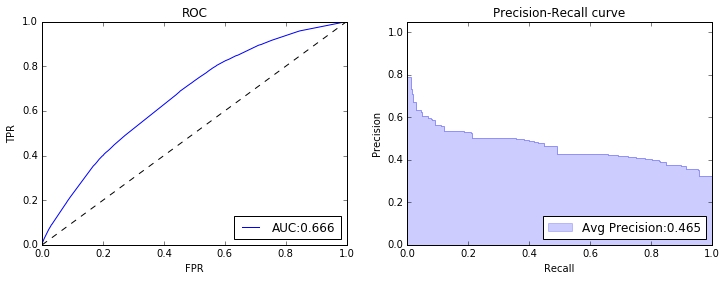

In [300]:
# baseline 1: nationality only 
CAT_FEATURES = ['nat_grouped']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS, 
                                                  print_summary=True) 
nat_model, nat_metrics, _, _, nat_truth, nat_pred  = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                  print_metrics=True, print_charts=True, print_cm=True)

Training Data: (193972, 369) | Test Data: (48494, 369)
Confusion Matrix:
[[31780   961]
 [14777   976]]
{'Recall': 0.061956452739160797, 'Log Loss': 0.60889885180209857, 'Precision': 0.50387196695921532, 'ROC AUC': 0.62559892973631825, 'Accuracy': 0.67546500598012127}


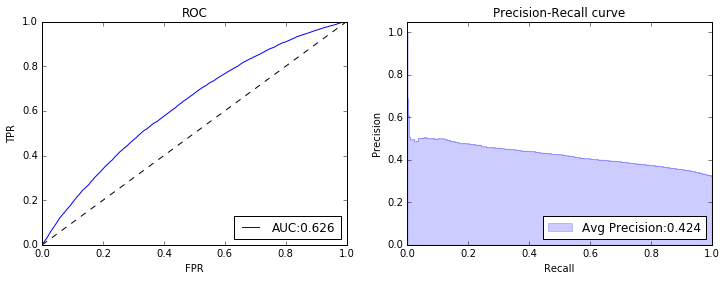

In [301]:
# baseline 2: judge only 
CAT_FEATURES = ['ij_code_grouped']
NUM_FEATURES = []
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS,
                                                  print_summary=True) 
ij_model, ij_metrics, _, _, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                               print_metrics=True, print_charts=True, print_cm=True)

Training Data: (193972, 499) | Test Data: (48494, 499)
Confusion Matrix:
[[28888  3853]
 [10456  5297]]
{'Recall': 0.33625341204849868, 'Log Loss': 0.76956138560172915, 'Precision': 0.57890710382513666, 'ROC AUC': 0.70127222542330014, 'Accuracy': 0.70493256897760548}


parent_feature
ij_code_grouped    0.572344
nat_grouped        0.427656
Name: importance, dtype: float64

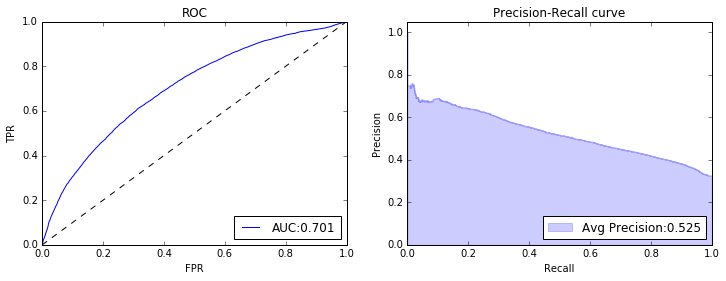

In [302]:
# baseline 3: nat + judge 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS,
                                                  print_summary=True) 
nat_ij_model, nat_ij_metrics, _, nat_ij_cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                print_metrics=True, print_charts=True, print_cm=True)
nat_ij_cfi

Training Data: (193972, 500) | Test Data: (48494, 500)
Confusion Matrix:
[[27968  4773]
 [ 7782  7971]]
{'Recall': 0.50599885736050276, 'Log Loss': 1.0730260125812308, 'Precision': 0.62547080979284364, 'ROC AUC': 0.76671602927150095, 'Accuracy': 0.74110199199901017}


parent_feature
ij_code_grouped        0.425924
datAppealFiled_year    0.325783
nat_grouped            0.248293
Name: importance, dtype: float64

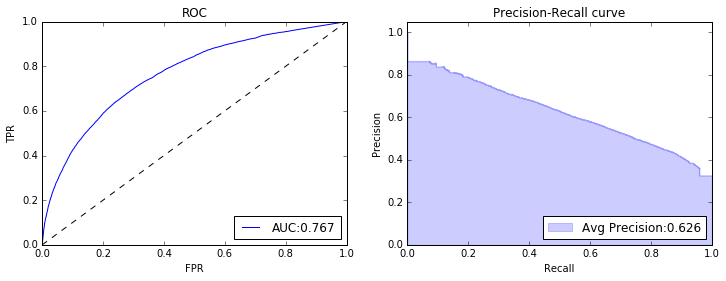

In [303]:
# baseline 4: nat + judge + appeal year 
CAT_FEATURES = ['nat_grouped', 'ij_code_grouped']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_grouped': 'none'}
MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS,
                                                  print_summary=True) 
nat_ij_year_model, nat_ij_year_metrics, _, nat_ij_year_cfi, _, _ = train_model(MODEL, X_train, y_train, X_test, y_test,
                                                                               print_metrics=True, print_charts=True, print_cm=True)
nat_ij_year_cfi

Training Data: (193972, 704) | Test Data: (48494, 704)
Confusion Matrix:
[[29875  2866]
 [ 7181  8572]]
{'Recall': 0.54415032057385893, 'Log Loss': 0.62044852225048663, 'Precision': 0.74943171883196358, 'ROC AUC': 0.84061266322043771, 'Accuracy': 0.79281973027591046}


parent_feature
nat_grouped                            0.099841
appeal_days_elapsed_since_comp_date    0.090005
comp_year_month                        0.074071
comp_days_elasped_since_input_date     0.068146
lang_grouped                           0.064470
ij_code_grouped                        0.064157
input_days_elapsed_since_osc_date      0.061791
datAppealFiled_year                    0.052376
base_city_code                         0.041227
last_10_appeal_grant_by_judge_nat      0.039542
last_10_appeal_grant_by_judge          0.039326
comp_year                              0.036489
years_since_law_school                 0.030760
years_since_judge_appointment          0.030473
original_dec_string                    0.025083
strCustody                             0.020010
Year_College_SLR                       0.016378
Year_Law_school_SLR                    0.016293
Year_Appointed_SLR                     0.016227
Government_Years_SLR                   0.012448
INS_Years_SLR            

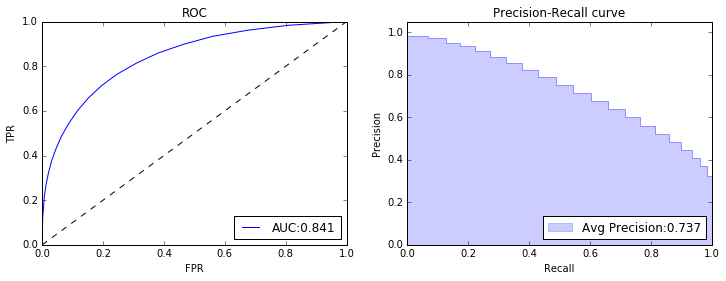

In [304]:
# full model 
FULL_CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'lang_grouped', 'case_type_string', 'Male_judge',
                     'strCustody', 'strProbono', 'original_dec_string', 'base_city_code', 'hearing_loc_match_base']
FULL_NUM_FEATURES = ['datAppealFiled_year', 'comp_year_month', 'lawyer', 'defensive', 'affirmative',
                     'oral', 'written', 'comp_year', 'Year_Appointed_SLR', 'Year_College_SLR',
                     'Year_Law_school_SLR', 'Government_Years_SLR', 'Govt_nonINS_SLR', 'INS_Years_SLR', 
                     'Military_Years_SLR', 'NGO_Years_SLR', 'Privateprac_Years_SLR', 'Academia_Years_SLR',
                     'judge_missing_bio', 'appeal_days_elapsed_since_comp_date', 'comp_days_elasped_since_input_date', 
                     'input_days_elapsed_since_osc_date', 'years_since_judge_appointment', 'years_since_law_school', 
                     'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat'] 

FULL_IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'Male_judge': 'none', 
                       'original_dec_string': 'none', 'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 
                       'written': 'zero', 'Year_Appointed_SLR': 'median', 'Year_College_SLR': 'median',
                       'Year_Law_school_SLR': 'median', 'Government_Years_SLR': 'median', 
                       'Govt_nonINS_SLR': 'median', 'INS_Years_SLR': 'median', 'Military_Years_SLR': 'median',
                       'NGO_Years_SLR': 'median', 'Privateprac_Years_SLR': 'median', 'Academia_Years_SLR': 'median',
                       'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median'} 

MODEL = (RandomForestClassifier(n_estimators=20, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, 
                                                  impute_methods = FULL_IMPUTE_METHODS, print_summary=True) 
rf_model, rf_metrics, rf_fi, rf_cfi, rf_truth, rf_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True, print_cm=True)
rf_cfi

In [305]:
baseline_comparison = {'Nationality Only': nat_metrics, 
                       'Judge Only': ij_metrics, 
                       'Nat + Judge': nat_ij_metrics, 
                       'Nat + Judge + Appeal Year': nat_ij_year_metrics, 
                       'Full Model': rf_metrics}

pd.DataFrame.from_dict(baseline_comparison, orient='index')

,Recall,Log Loss,Precision,ROC AUC,Accuracy
Full Model,0.544150,0.620449,0.749432,0.840613,0.792820
Judge Only,0.061956,0.608899,0.503872,0.625599,0.675465
Nat + Judge,0.336253,0.769561,0.578907,0.701272,0.704933
Nat + Judge + Appeal Year,0.505999,1.073026,0.625471,0.766716,0.741102
Nationality Only,0.109186,0.590990,0.565232,0.665874,0.683342


### Try Other Tree-Based Models

#### Gradient Boosting

Confusion Matrix:
[[30616  2125]
 [11458  4295]]
{'Recall': 0.27264648003554881, 'Log Loss': 0.5613303621166984, 'Precision': 0.6690031152647975, 'ROC AUC': 0.73608265982296694, 'Accuracy': 0.7199034932156555}


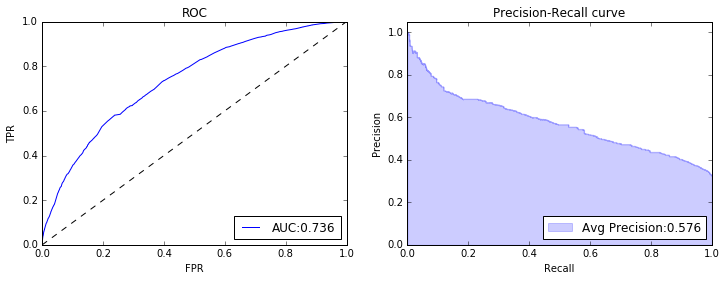

In [306]:
MODEL = (GradientBoostingClassifier(loss='deviance', learning_rate=.1, n_estimators=20, random_state=44))
X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS)
gb_model, gb_metrics, gb_fi, gb_cfi, gb_truth, gb_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True, print_cm=True)

#### XGBoost 

Confusion Matrix:
[[29699  3042]
 [10570  5183]]
{'Recall': 0.32901669523265409, 'Log Loss': 0.56454897717077146, 'Precision': 0.63015197568389059, 'ROC AUC': 0.73093815784843652, 'Accuracy': 0.71930548109044423}


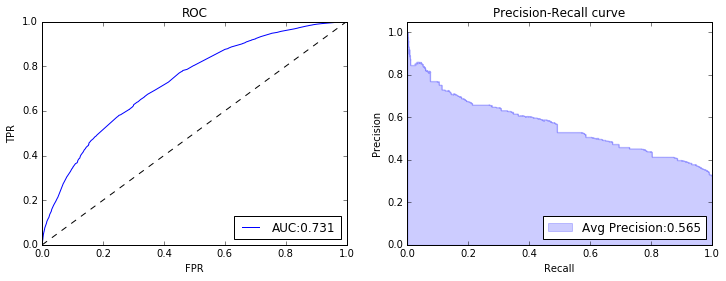

In [307]:
MODEL = (XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=20, seed=44))
X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS)
xgb_model, xgb_metrics, xgb_fi, xgb_cfi, xgb_truth, xgb_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                           print_metrics=True, print_charts=True, print_cm=True)

#### Logistic Regression 

Confusion Matrix:
[[29742  2999]
 [10559  5194]]
{'Recall': 0.32971497492541102, 'Log Loss': 0.54780185570152262, 'Precision': 0.63395581594043693, 'ROC AUC': 0.74211611600762195, 'Accuracy': 0.72041902090980325}


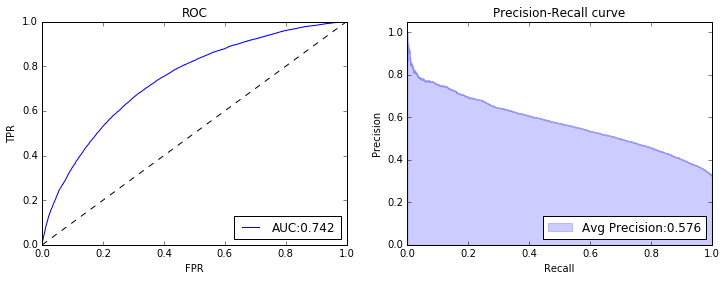

In [308]:
MODEL = (LogisticRegression(penalty='l2', C=1))
X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS) 
lr_model, lr_metrics, lr_fi, lr_cfi, lr_truth, lr_pred = train_model(MODEL, X_train, y_train, X_test, y_test, 
                                                                     print_metrics=True, print_charts=True, print_cm=True)

#### Algorithm Comparison (out-of-the-box)

In [309]:
algo_comparison = {'Random Forest': rf_metrics, 
                   'Gradient Boosting': gb_metrics, 
                   'XGBoost': xgb_metrics, 
                   'Logistic Regression': lr_metrics}

pd.DataFrame.from_dict(algo_comparison, orient='index').sort_values(by='ROC AUC', ascending=False)

,Recall,Log Loss,Precision,ROC AUC,Accuracy
Random Forest,0.544150,0.620449,0.749432,0.840613,0.792820
Logistic Regression,0.329715,0.547802,0.633956,0.742116,0.720419
Gradient Boosting,0.272646,0.561330,0.669003,0.736083,0.719903
XGBoost,0.329017,0.564549,0.630152,0.730938,0.719305


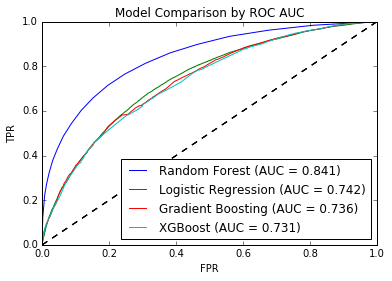

In [310]:
# plot all ROC in a single chart 
plot_roc(rf_truth, rf_pred, 'Random Forest')
plot_roc(lr_truth, lr_pred, 'Logistic Regression')
plot_roc(gb_truth, gb_pred, 'Gradient Boosting')
plot_roc(xgb_truth, xgb_pred, 'XGBoost')
plt.title('Model Comparison by ROC AUC'); 

Since Random Forest outperforms other algorithms significantly in accuracy and ROC AUC out-of-the-box, we will move forward with Random Forest and tune it to get our best model.  

### Tune Random Forest 

In [26]:
# define search scope 
max_features = ['sqrt']
max_depth = list(np.arange(60, 140, 20))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# construct param grid 
param_grid = {'max_features': max_features, 'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# run randomized search cv 
X_train, _, y_train, _ = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                        num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS) 
rf_clf = RandomForestClassifier(n_estimators=20, random_state=44)
rf_gridsearch = GridSearchCV(rf_clf, param_grid, scoring=['roc_auc', 'accuracy', 'neg_log_loss'], refit='roc_auc')
rf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=44, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt'], 'min_samples_split': [2, 5, 10], 'max_depth': [60, 80, 100, 120, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=['roc_auc', 'accuracy', 'neg_log_loss'], verbose=0)

In [29]:
def evaluate_search_cv(cv_object): 
    """ Print results for randomized search cv """
    rename_cols = {'param_max_depth': 'max_depth', 
                   'param_max_features': 'max_features', 
                   'param_min_samples_leaf': 'min_samples_leaf', 
                   'param_min_samples_split': 'min_samples_split', 
                   'mean_test_roc_auc': 'roc_auc', 
                   'mean_test_accuracy': 'accuracy', 
                   'mean_train_neg_log_loss': 'neg_log_loss'}
    results = pd.DataFrame(cv_object.cv_results_)
    results.rename(columns=rename_cols, inplace=True)
    results = results[['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 
                       'roc_auc', 'accuracy', 'neg_log_loss']]
    return results.sort_values(by='roc_auc', ascending=False)

In [30]:
evaluate_search_cv(rf_gridsearch)

,max_depth,max_features,min_samples_leaf,min_samples_split,roc_auc,accuracy,neg_log_loss
0,60,sqrt,1,2,0.825386,0.779721,-0.133290
1,60,sqrt,1,5,0.824987,0.780144,-0.229216
19,100,sqrt,1,5,0.824967,0.781066,-0.224457
10,80,sqrt,1,5,0.824951,0.780927,-0.224983
28,120,sqrt,1,5,0.824832,0.780984,-0.224403
37,None,sqrt,1,5,0.824832,0.780984,-0.224403
9,80,sqrt,1,2,0.824683,0.781530,-0.125671
2,60,sqrt,1,10,0.823616,0.778056,-0.295790
38,None,sqrt,1,10,0.823493,0.777798,-0.292004
20,100,sqrt,1,10,0.823493,0.777798,-0.292004


In [31]:
print(rf_gridsearch.best_params_)

{'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 60, 'min_samples_leaf': 1}


Confusion Matrix:
[[29947  2794]
 [ 6874  8879]]
{'Recall': 0.56363867199898432, 'Log Loss': 0.44261361965575691, 'Precision': 0.76064422170821555, 'ROC AUC': 0.85461405023291315, 'Accuracy': 0.80063513011918996}


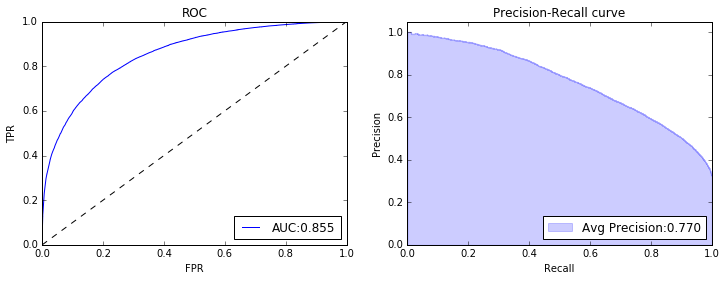

In [311]:
# retrain with best params on 100 trees 
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=2, max_features='sqrt', 
                                max_depth=60, min_samples_leaf=1, random_state=44))

X_train, X_test, y_train, y_test = get_model_data(df, df, label='granted', cat_features = FULL_CAT_FEATURES, 
                                                  num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS) 
rf_best_model, rf_best_metrics, rf_best_fi, rf_best_cfi, rf_best_truth, rf_best_pred = train_model(
    MODEL, X_train, y_train, X_test, y_test, print_metrics=True, print_charts=True, print_cm=True)

In [312]:
algo_comparison_tuned = {'Random Forest (Tuned + More Trees)': rf_best_metrics,
                         'Random Forest': rf_metrics} 

pd.DataFrame.from_dict(algo_comparison_tuned, orient='index').sort_values(by='ROC AUC', ascending=False)

,Recall,Log Loss,Precision,ROC AUC,Accuracy
Random Forest (Tuned + More Trees),0.563639,0.442614,0.760644,0.854614,0.800635
Random Forest,0.544150,0.620449,0.749432,0.840613,0.792820


In [313]:
# check feature importances 
rf_best_fi.head(20)

appeal_days_elapsed_since_comp_date          0.095084
comp_year_month                              0.071465
comp_days_elasped_since_input_date           0.067444
input_days_elapsed_since_osc_date            0.061351
datAppealFiled_year                          0.048937
last_10_appeal_grant_by_judge_nat            0.040192
last_10_appeal_grant_by_judge                0.038577
comp_year                                    0.037828
years_since_law_school                       0.030516
years_since_judge_appointment                0.029674
Year_College_SLR                             0.016537
Year_Law_school_SLR                          0.016203
Year_Appointed_SLR                           0.015416
nat_grouped:::EL SALVADOR                    0.013624
Government_Years_SLR                         0.012602
Privateprac_Years_SLR                        0.012225
INS_Years_SLR                                0.012173
Govt_nonINS_SLR                              0.009818
lang_grouped:::SP           

In [314]:
# check collapsed feature importances 
rf_best_cfi

parent_feature
nat_grouped                            0.101285
appeal_days_elapsed_since_comp_date    0.095084
comp_year_month                        0.071465
comp_days_elasped_since_input_date     0.067444
lang_grouped                           0.065791
ij_code_grouped                        0.063967
input_days_elapsed_since_osc_date      0.061351
datAppealFiled_year                    0.048937
base_city_code                         0.042080
last_10_appeal_grant_by_judge_nat      0.040192
last_10_appeal_grant_by_judge          0.038577
comp_year                              0.037828
years_since_law_school                 0.030516
years_since_judge_appointment          0.029674
original_dec_string                    0.025074
strCustody                             0.020096
Year_College_SLR                       0.016537
Year_Law_school_SLR                    0.016203
Year_Appointed_SLR                     0.015416
Government_Years_SLR                   0.012602
Privateprac_Years_SLR    

In [315]:
# save model to pickle 
import pickle
model_pkl_fname = "aggregate_random_forest_vF.pkl"
#model_pkl_fname = os.path.join(DATAFOLDER, 'aggregate_random_forest_v0.pkl') # doesn't work? 
with open(model_pkl_fname, 'wb') as file:  
    pickle.dump(rf_best_model, file)

### Probability Calibration

Probability calibration can sometimes be an issue for random forest. But it appears that our classifier is already well-calibrated, so we deem it unnecessary to proceed with calibration methods like Platt Scaling. 

In [316]:
y_pred_outofbox = rf_model.predict_proba(X_test)[:,1]
y_pred_best = rf_best_model.predict_proba(X_test)[:,1]
calibration_outofbox = calibration_curve(y_test, y_pred_outofbox, n_bins=10)
calibration_best = calibration_curve(y_test, y_pred_best, n_bins=10)

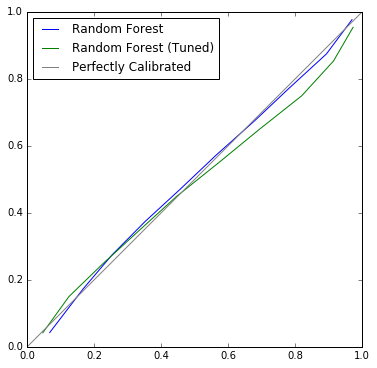

In [317]:
plt.figure(figsize=(6, 6))
plt.plot(calibration_outofbox[0], calibration_outofbox[1], label='Random Forest')
plt.plot(calibration_best[0], calibration_best[1], label='Random Forest (Tuned)')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='Perfectly Calibrated', color='grey')
plt.legend(loc='best');

# Sequential Models

Thus far we aggregated data across time as a single population from which we drew train and test samples from. This might not be the most realistic way to build a model that is used to predict future appeal outcomes (i.e. we do not have the luxury of using data from future appeals to inform the outcome of a current appeal). To more realistically assess the power of our predictive models, we will build a sequence of models: one model to predict each year's of appeals (by datAppealFiled_year) between 1991 and 2013 using data in preceeding years. In other words, we will only use data from 2000 and earlier to predict 2001's appeals, data from 2001 and earlier to predict 2002's appeals etc. 

In [62]:
def get_model_data_by_year(df, appeals_df, label, unique_id, cat_features, num_features, impute_methods, predict_year): 
    """ Generates features on data for years prior to predict_year """

    # add 'datAppealFiled_year' if not in num_features 
    if 'datAppealFiled_year' not in num_features: 
        num_features_ = num_features + ['datAppealFiled_year'] 
    else: 
        num_features_ = num_features 

    # subsets features we are interested in 
    cat_feature_values = dict([(f, [str(x) for x in df[f].dropna().unique().tolist()]) for f in cat_features]) 
    data = df.set_index(unique_id)
    if label is not None: 
        data = data[cat_features + num_features_ + [label]].copy() 
    else: 
        data = data[cat_features + num_features].copy()

    # train test split 
    train_data = data[data['datAppealFiled_year'] < predict_year]
    test_data = data[data['datAppealFiled_year'] == predict_year]
    
    # return y=None if label is not passed (used for parsing data for pure predictions)
    if label is not None: 
        x_train, y_train = train_data.drop(label, axis=1).copy(), train_data[label].copy() 
        x_test, y_test = test_data.drop(label, axis=1).copy(), test_data[label].copy() 
    else: 
        x_train, y_train = train_data, None 
        x_test, y_test = test_data, None 

    # transform 
    X_train = transform_features(x_train, appeals_df, cat_features, num_features, impute_methods)
    X_test = transform_features(x_test, appeals_df, cat_features, num_features, impute_methods)

    return X_train, X_test, y_train, y_test 

In [324]:
def fit_sequential_models(df, model, label, cat_features, num_features, impute_methods, 
                          start_year, end_year, weight_decay=None, print_charts=False, print_metrics=True): 
    """ Trains a sequence of models using data from preceeding years to test on current year 
        TODO: modularize this if have time"""
    
    # initialize empty dictionary to collect all results 
    sequential_results = {}
    model_list = [] 
    
    # loop through each year to train model on data from preceeding years then test on current year 
    for i, year in enumerate(np.arange(start_year, end_year+1, 1)): 
        print("Training model to predict {} appeals...".format(year)) 
        result = {} # initialize empty dictionary to collect result for each year 
        model_list.append(clone(model)) # create a new copy of the model to train on new subset of data
        X_train, X_test, y_train, y_test = get_model_data_by_year(
            df, df, label='granted', unique_id='idnproceeding', cat_features=cat_features, num_features=num_features, 
            impute_methods=impute_methods, predict_year=year) 
        
        # weight samples 
        if weight_decay is not None:
            print(weight_decay)
            sample_weight = X_train['datAppealFiled_year'].apply(lambda x: weight_decay ** (year-x-1))
        else: 
            sample_weight = None 
        
        # datAppealFiled_year is included in X_train by default; remove if not in num_features
        if 'datAppealFiled_year' not in num_features: 
            X_train = X_train[[c for c in X_train.columns if c != 'datAppealFiled_year']]
            X_test = X_test[[c for c in X_train.columns if c != 'datAppealFiled_year']]
        else: 
            pass 
        
        # save results to dictionary 
        result['model'], result['metrics'], result['fi'], result['cfi'], result['truth'], result['pred'] = train_model(
            model_list[i], X_train, y_train, X_test, y_test, 
            print_charts=print_charts, print_metrics=print_metrics, sample_weight=sample_weight) 
        sequential_results[year] = result 
        
    # summarize model performance metrics 
    metric_summary = pd.DataFrame.from_dict(sequential_results, orient='index')['metrics'].apply(pd.Series)
    print(metric_summary)
    print("Average model performance metrics:")
    print(metric_summary.mean()) 
    plot_sequential_performance(metric_summary)
    
    # average feature importances 
    average_cfi = pd.DataFrame.from_dict(sequential_results, orient='index')['cfi']\
                              .apply(pd.Series).mean().sort_values(ascending=False)
    print("Average feature importances:")
    print(average_cfi)     
    
    return metric_summary, average_cfi, sequential_results 

In [70]:
def plot_sequential_performance(sequential_metrics):
    """ Plots AUC and Accuracy by test year """
    plt.figure(figsize=(10, 4))
    plt.plot(sequential_metrics['ROC AUC'])
    plt.plot(sequential_metrics['Accuracy'])
    plt.ticklabel_format(useOffset=False)
    plt.title('Accuracy and AUC of Sequential Models')
    plt.xlabel('Test Year')
    plt.legend(loc='best') 

It appears that building the model in a sequential way degraded the performance considerably. Perhaps even more surprisingly, accuracy appears to be worse in later years, which is somewhat counterintuitive given that later models had more data to train on. 

Training model to predict 1994 appeals...
{'Recall': 0.47859922178988329, 'Log Loss': 0.57400772406200151, 'Precision': 0.68333333333333335, 'ROC AUC': 0.76428669113421688, 'Accuracy': 0.69531405782652045}
Training model to predict 1995 appeals...
{'Recall': 0.4748148148148148, 'Log Loss': 0.52763525628691743, 'Precision': 0.67261280167890869, 'ROC AUC': 0.77440610703481361, 'Accuracy': 0.75088446992802249}
Training model to predict 1996 appeals...
{'Recall': 0.46927374301675978, 'Log Loss': 0.55254506020323113, 'Precision': 0.7446179822710004, 'ROC AUC': 0.78928452409177907, 'Accuracy': 0.73885094415427888}
Training model to predict 1997 appeals...
{'Recall': 0.45844193454966697, 'Log Loss': 0.60659867324574435, 'Precision': 0.66568544995794787, 'ROC AUC': 0.728541902095592, 'Accuracy': 0.66248733535967574}
Training model to predict 1998 appeals...
{'Recall': 0.37960810362005976, 'Log Loss': 0.59321103435894762, 'Precision': 0.61650485436893199, 'ROC AUC': 0.72145764007839164, 'Accura

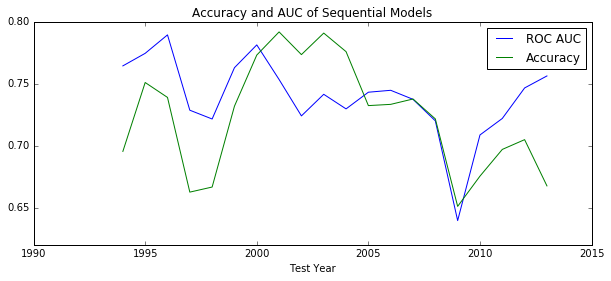

In [71]:
# test with same variables as rf_best
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=2, max_features='sqrt', 
                                max_depth=60, min_samples_leaf=1, random_state=44))
sequential_metrics, average_cfi, sequential_results = fit_sequential_models(
    df, MODEL, 'granted', cat_features=FULL_CAT_FEATURES, num_features=FULL_NUM_FEATURES, 
    impute_methods=FULL_IMPUTE_METHODS, start_year=1994, end_year=2013, print_charts=False, print_metrics=True)

### Applying weight decay to samples

One reason could be that there are periodic shifts in sentiment such that older data might be less informative to newer cases. Let's attempt to weight recent samples more than older samples. 

In [73]:
# try different values of alpha 

def tune_weight_decay(df, model, label, cat_features, num_features, impute_methods, start_year, end_year, weight_decay_alphas):
    results = [] 
    for alpha in weight_decay_alphas: 
        result = {} 
        metrics_summary, _, _ = fit_sequential_models(
            df, model, 'granted', cat_features=FULL_CAT_FEATURES, num_features=FULL_NUM_FEATURES, 
            impute_methods=FULL_IMPUTE_METHODS, start_year=start_year, end_year=end_year, weight_decay=alpha, 
            print_metrics=False, print_charts=False)
        result['alpha'] = alpha 
        result['average_accuracy'] = metrics_summary['Accuracy'].mean() 
        result['average_roc_auc'] = metrics_summary['ROC AUC'].mean() 
        result['average_log_loss'] = metrics_summary['Log Loss'].mean() 
        result['average_precision'] = metrics_summary['Precision'].mean() 
        result['average_recall'] = metrics_summary['Recall'].mean() 
        results.append(result)
    return pd.DataFrame(results)

Training model to predict 1994 appeals...
0.1
Training model to predict 1995 appeals...
0.1
Training model to predict 1996 appeals...
0.1
Training model to predict 1997 appeals...
0.1
Training model to predict 1998 appeals...
0.1
Training model to predict 1999 appeals...
0.1
Training model to predict 2000 appeals...
0.1
Training model to predict 2001 appeals...
0.1
Training model to predict 2002 appeals...
0.1
Training model to predict 2003 appeals...
0.1
Training model to predict 2004 appeals...
0.1
Training model to predict 2005 appeals...
0.1
Training model to predict 2006 appeals...
0.1
Training model to predict 2007 appeals...
0.1
Training model to predict 2008 appeals...
0.1
Training model to predict 2009 appeals...
0.1
Training model to predict 2010 appeals...
0.1
Training model to predict 2011 appeals...
0.1
Training model to predict 2012 appeals...
0.1
Training model to predict 2013 appeals...
0.1
      Accuracy  Log Loss  Precision   ROC AUC    Recall
1994  0.676171  0.667442

,alpha,average_accuracy,average_log_loss,average_precision,average_recall,average_roc_auc
0,0.1,0.712178,0.666482,0.610148,0.333150,0.715305
1,0.2,0.712534,0.683608,0.615275,0.328100,0.715729
2,0.3,0.714432,0.687235,0.618491,0.335691,0.717999
3,0.4,0.714678,0.678344,0.615334,0.340360,0.719400
4,0.5,0.714336,0.690848,0.612270,0.346233,0.718976
5,0.6,0.714113,0.680488,0.611946,0.347515,0.717488
6,0.7,0.713208,0.686808,0.607312,0.348836,0.717806
7,0.8,0.712582,0.665218,0.605380,0.349522,0.717231
8,0.9,0.713175,0.675666,0.606180,0.353307,0.718597
9,1.0,0.711440,0.670221,0.602486,0.345583,0.714738


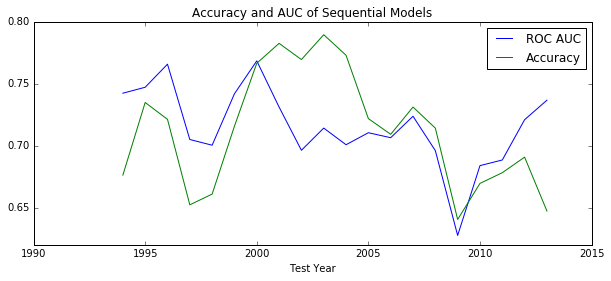

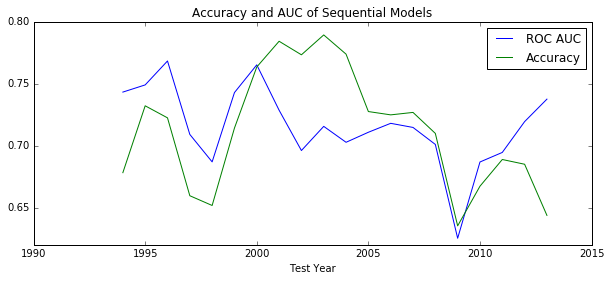

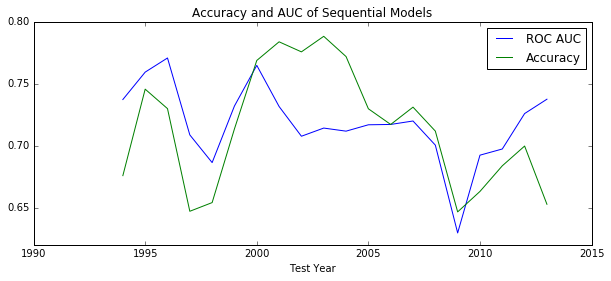

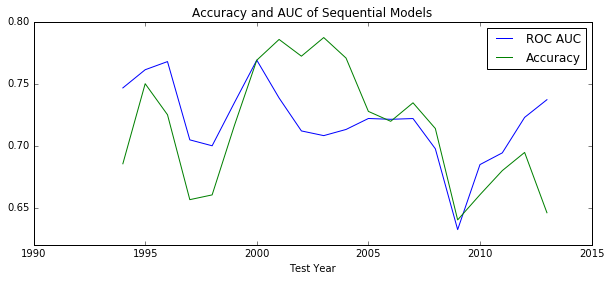

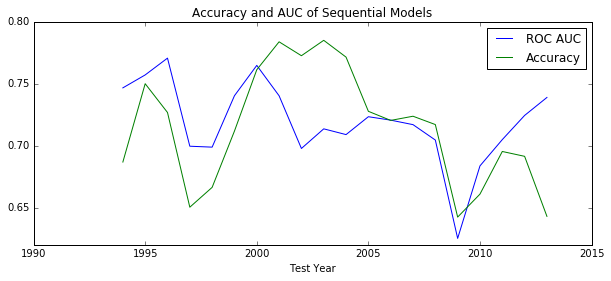

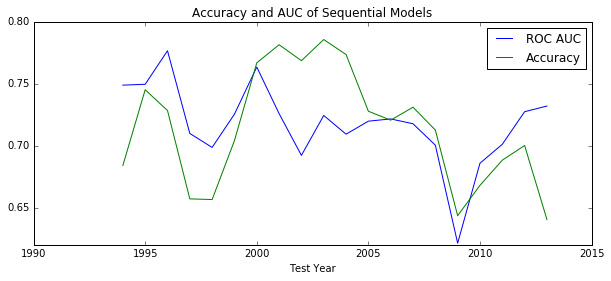

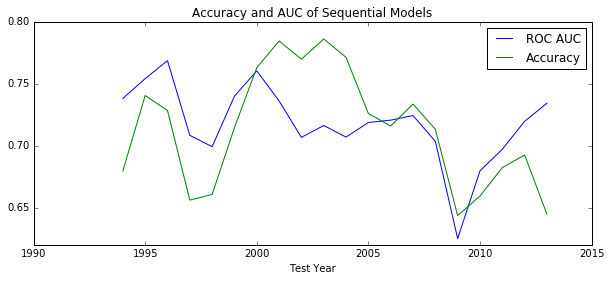

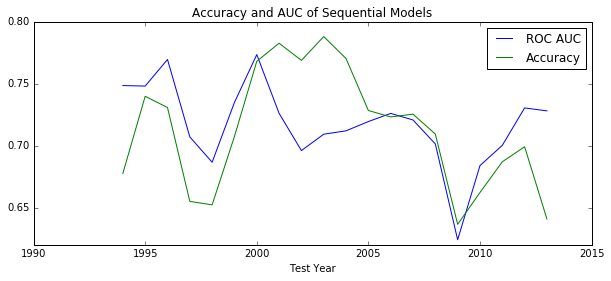

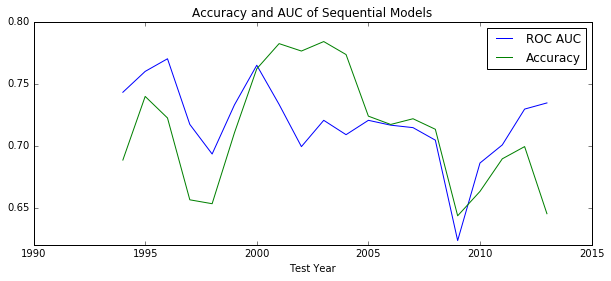

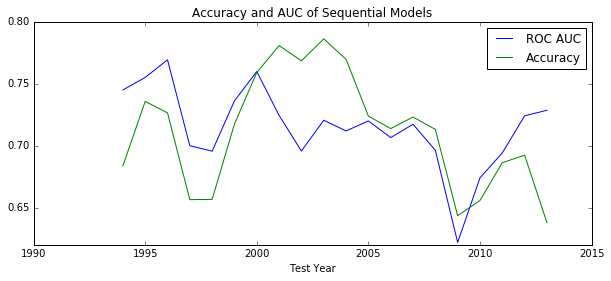

In [74]:
# find best alpha
MODEL = (RandomForestClassifier(n_estimators=20, min_samples_split=2, max_features='sqrt', 
                                max_depth=60, min_samples_leaf=1, random_state=44))
weight_decay_tuning = tune_weight_decay(df, MODEL, 'granted', cat_features=FULL_CAT_FEATURES, 
                                        num_features=FULL_NUM_FEATURES, impute_methods=FULL_IMPUTE_METHODS, 
                                        start_year=1994, end_year=2013, 
                                        weight_decay_alphas=[.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
weight_decay_tuning

Training model to predict 1994 appeals...
0.9
{'Recall': 0.47908560311284049, 'Log Loss': 0.57749123559824056, 'Precision': 0.68024861878453036, 'ROC AUC': 0.75996292719040903, 'Accuracy': 0.69411764705882351}
Training model to predict 1995 appeals...
0.9
{'Recall': 0.46481481481481479, 'Log Loss': 0.52105512970431955, 'Precision': 0.68466993998908887, 'ROC AUC': 0.77987188297994181, 'Accuracy': 0.75320239111870202}
Training model to predict 1996 appeals...
0.9
{'Recall': 0.45411013567438147, 'Log Loss': 0.55089955118081002, 'Precision': 0.73356252685861623, 'ROC AUC': 0.7864009707346229, 'Accuracy': 0.73161912414624342}
Training model to predict 1997 appeals...
0.9
{'Recall': 0.45844193454966697, 'Log Loss': 0.60382612077984632, 'Precision': 0.67505330490405113, 'ROC AUC': 0.73300630915299436, 'Accuracy': 0.66666666666666663}
Training model to predict 1998 appeals...
0.9
{'Recall': 0.37695117901029557, 'Log Loss': 0.59288728972182569, 'Precision': 0.62055768179332971, 'ROC AUC': 0.719

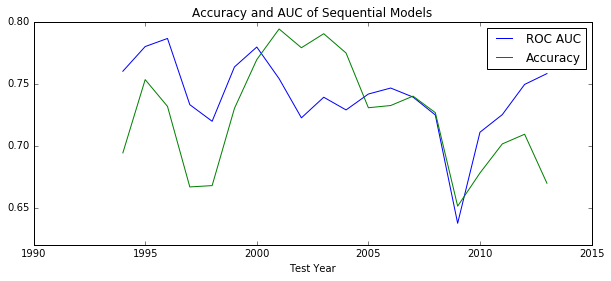

In [327]:
# choose alpha=0.9 and re-run 
MODEL = (RandomForestClassifier(n_estimators=100, min_samples_split=2, max_features='sqrt', 
                                max_depth=60, min_samples_leaf=1, random_state=44))
sequential_metrics_wt, average_cfi_wt, sequential_results_wt = fit_sequential_models(
    df, MODEL, 'granted', cat_features=FULL_CAT_FEATURES, num_features=FULL_NUM_FEATURES, 
    impute_methods=FULL_IMPUTE_METHODS, start_year=1994, end_year=2013, weight_decay=0.9, 
    print_charts=False, print_metrics=True)

In [328]:
# save sequential models as a tuple to pickle 
import pickle
seq_model_pkl_fname = "sequential_random_forest_vF.pkl" 
#seq_model_pkl_fname = os.path.join(DATAFOLDER, 'sequential_random_forest_vF.pkl') # doesn't work? 
models_object = tuple([sequential_results_wt[year]['model'] for year in sequential_results_wt.keys()]) 
with open(seq_model_pkl_fname, "wb") as f:
    pickle.dump(models_object, f)

### Compare Feature Importances

In [280]:
# compare feature importances   
compare_cfi = pd.concat([rf_best_cfi, average_cfi_wt], axis=1)
compare_cfi.columns = ['aggregate', 'sequential']
compare_cfi['delta'] = compare_cfi['sequential'] - compare_cfi['aggregate']
compare_cfi = compare_cfi[(compare_cfi['aggregate'] > 0.01) | (compare_cfi['sequential'] > 0.01)]
compare_cfi = compare_cfi.sort_values(by='aggregate', ascending=True)

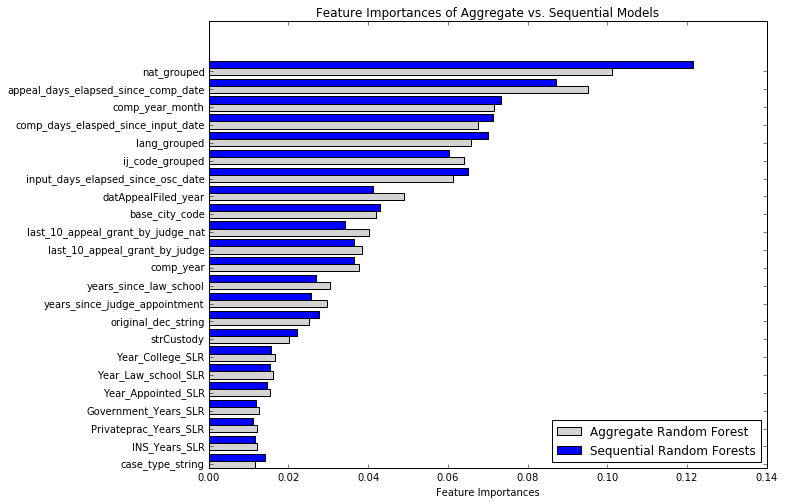

In [281]:
# plot comparison of feature importances 

ind = np.arange(len(compare_cfi))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 8)) 
agg = ax.barh(ind, compare_cfi['aggregate'], width, color='lightgrey', label='Aggregate Random Forest')
seq = ax.barh(ind+width, compare_cfi['sequential'], width, color='blue', label='Sequential Random Forests')

ax.set_xlabel('Feature Importances')
ax.set_title('Feature Importances of Aggregate vs. Sequential Models')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels((compare_cfi.index))
plt.legend(loc='best');

### Compare Accuracy and AUC 

In [238]:
# get aggregate model test accuracy and roc by year 

def summarize_perf_by_year(y_test, pred, full_data, start_year, end_year):
    
    """ Returns accuracy and roc grouped by year from aggregate model results """
    
    # join predictions back to year 
    agg_results = pd.DataFrame(y_test)
    agg_results.rename(columns={'granted': 'truth'}, inplace=True)
    agg_results['pred_proba'] = pred 
    agg_results['pred'] = (agg_results['pred_proba']>0.5).astype(int)
    agg_results = agg_results.merge(df[['datAppealFiled_year']], how='left', left_index=True, right_index=True)
    
    # loop through each year to get accuracy and auc 
    results = [] 
    for year in np.arange(start_year, end_year+1, 1): 
        result = {}
        df_year = agg_results[agg_results['datAppealFiled_year'] == year]
        result['datAppealFiled_year'] = year
        result['accuracy'] = accuracy_score(df_year['truth'], df_year['pred'])
        result['roc_auc'] = roc_auc_score(df_year['truth'], df_year['pred_proba'])
        results.append(result)

    results_df = pd.DataFrame(results).set_index('datAppealFiled_year')
    return results_df[['accuracy', 'roc_auc']]

agg_perf_by_year = summarize_perf_by_year(y_test, rf_best_pred, df, 1994, 2013)

In [246]:
perf_comparison = agg_perf_by_year.merge(sequential_metrics_wt[['Accuracy', 'ROC AUC']], 
                                         how='left', left_index=True, right_index=True)
perf_comparison.rename(columns={'accuracy': 'Accuracy (Agg)', 'roc_auc': 'ROC AUC (Agg)', 
                                'Accuracy': 'Accuracy (Seq-W)', 'ROC AUC': 'ROC AUC (Seq-W)'}, inplace=True)
perf_comparison = perf_comparison.merge(sequential_metrics[['Accuracy', 'ROC AUC']], 
                                        how='left', left_index=True, right_index=True)
perf_comparison.rename(columns={'Accuracy': 'Accuracy (Seq-UW)', 'ROC AUC': 'ROC AUC (Seq-UW)'}, inplace=True)
perf_comparison = perf_comparison[['Accuracy (Agg)', 'Accuracy (Seq-UW)', 'Accuracy (Seq-W)', 
                                   'ROC AUC (Agg)', 'ROC AUC (Seq-UW)', 'ROC AUC (Seq-W)']]
perf_comparison

,Accuracy (Agg),Accuracy (Seq-UW),Accuracy (Seq-W),ROC AUC (Agg),ROC AUC (Seq-UW),ROC AUC (Seq-W)
datAppealFiled_year,,,,,,
1994,0.787698,0.695314,0.694118,0.855526,0.764287,0.759963
1995,0.831089,0.750884,0.753202,0.866632,0.774406,0.779872
1996,0.789392,0.738851,0.731619,0.862333,0.789285,0.786401
1997,0.786037,0.662487,0.666667,0.863667,0.728542,0.733006
1998,0.755128,0.666580,0.667744,0.824326,0.721458,0.719627
1999,0.792117,0.731792,0.730005,0.854165,0.762832,0.763430
2000,0.825964,0.773012,0.769325,0.851187,0.781207,0.779490
2001,0.847162,0.791681,0.794042,0.840753,0.753294,0.753983
2002,0.814441,0.773376,0.778919,0.828669,0.723952,0.722385


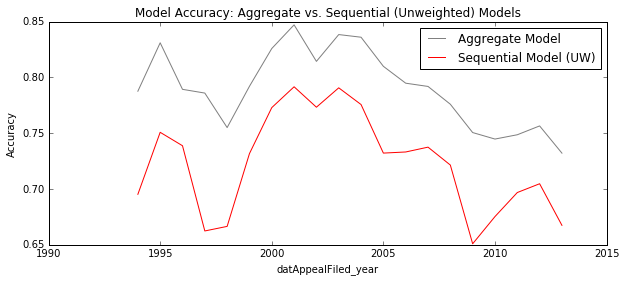

In [278]:
# compare aggregate vs. sequential (unweighted)
plt.figure(figsize=(10, 4))
plt.plot(perf_comparison['Accuracy (Agg)'], color='grey', label='Aggregate Model')
plt.plot(perf_comparison['Accuracy (Seq-UW)'], color='red', label='Sequential Model (UW)')
plt.xlabel('datAppealFiled_year')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Aggregate vs. Sequential (Unweighted) Models')
plt.legend(loc='best'); 

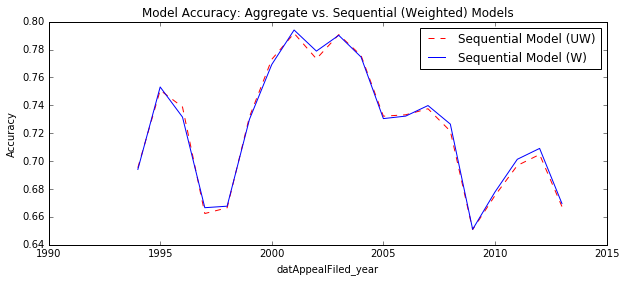

In [284]:
# compare sequential (unweighted) vs. sequential (weighted)
plt.figure(figsize=(10, 4))
plt.plot(perf_comparison['Accuracy (Seq-UW)'], linestyle='--', color='red', label='Sequential Model (UW)')
plt.plot(perf_comparison['Accuracy (Seq-W)'], color='blue', label='Sequential Model (W)')
plt.xlabel('datAppealFiled_year')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Aggregate vs. Sequential (Weighted) Models')
plt.legend(loc='best'); 